# Stress Detection using Wearable Devices to Enhance Well-Being | Model Training

ID Tim: CC25-CR439

## Import Library

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import seaborn as sns
import matplotlib.pyplot as plt

2025-06-12 22:43:30.863475: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749768211.072149      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749768211.135737      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Data Loading & Preparation

In [2]:
dataset_dir = '/kaggle/input/wesad-combined-feature-extracted/combined.csv'
df = pd.read_csv(dataset_dir)
df = df.drop(columns=['Unnamed: 0'])

In [3]:
# Memilih Fitur (X) dan Target (y)
# Hapus kolom yang tidak relevan untuk menjadi fitur
features = df.drop(columns=['timestamp', 'label', 'subject'])
target = df['label']

In [4]:
# Konversi ke Masalah Klasifikasi Biner
# Mengubah label menjadi 0 (non-stres) dan 1 (stres)
# Label 2 adalah 'stress', sedangkan 1 ('baseline') dan 3 ('amusement') adalah 'non-stress'
y_binary = target.apply(lambda x: 1 if x == 2 else 0)
X = features

In [5]:
# Pembagian Data (Train-Test Split) Berdasarkan Subjek
# Metode ini dipilih karena lebih baik daripada split acak seperti biasanya
# karena memastikan model diuji pada subjek yang belum pernah dilihat sebelumnya.
subjects = df['subject'].unique()
train_subjects, test_subjects = train_test_split(subjects, test_size=0.3, random_state=42)

# Buat set data train dan test berdasarkan subjek yang telah dibagi
train_indices = df['subject'].isin(train_subjects)
test_indices = df['subject'].isin(test_subjects)

X_train, X_test = X[train_indices], X[test_indices]
y_train, y_test = y_binary[train_indices], y_binary[test_indices]

print(f"Jumlah data training: {len(X_train)}")
print(f"Jumlah data testing: {len(X_test)}")
print("-" * 30)

Jumlah data training: 88628
Jumlah data testing: 43995
------------------------------


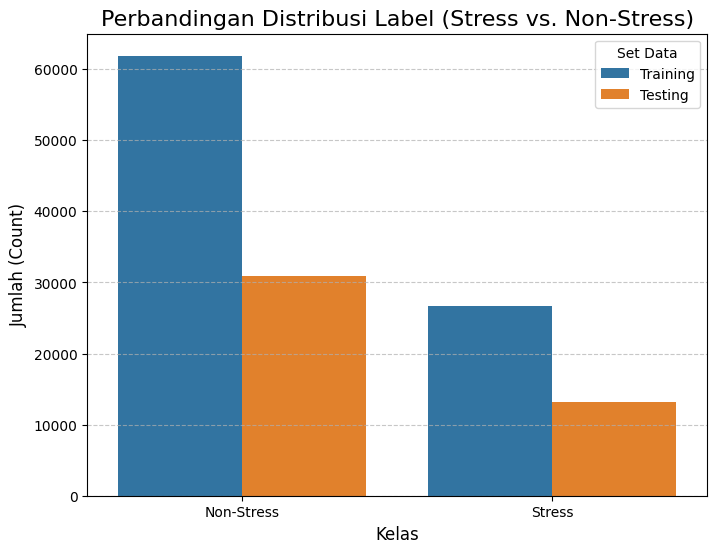

In [6]:
# Melihat distribusi label pada train dan test
train_df = pd.DataFrame({'label': y_train, 'Set': 'Training'})
test_df = pd.DataFrame({'label': y_test, 'Set': 'Testing'})
combined_df = pd.concat([train_df, test_df])

# Buat plot menggunakan seaborn.countplot
plt.figure(figsize=(8, 6))
sns.countplot(data=combined_df, x='label', hue='Set')

plt.title('Perbandingan Distribusi Label (Stress vs. Non-Stress)', fontsize=16)
plt.xlabel('Kelas', fontsize=12)
plt.ylabel('Jumlah (Count)', fontsize=12)
plt.xticks(ticks=[0, 1], labels=['Non-Stress', 'Stress'])
plt.legend(title='Set Data')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

In [7]:
# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Modelling

In [8]:
# Menentukan jumlah fitur input untuk layer pertama
num_features = X_train_scaled.shape[1]

# Membangun model sekuensial dengan Keras
model = tf.keras.Sequential([
    # Input Layer (Dense) dengan 'relu' activation
    tf.keras.layers.Dense(64, activation='relu', input_shape=(num_features,)),
    # Dropout untuk regularisasi (mencegah overfitting)
    tf.keras.layers.Dropout(0.5),
    
    # Hidden Layer
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    
    # Output Layer
    # Menggunakan 1 neuron dengan aktivasi 'sigmoid' untuk klasifikasi biner
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Menampilkan ringkasan arsitektur model
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1749768227.544591      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1749768227.545423      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 64)                  │           1,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,649 (14.25 KB)

 Trainable params: 3,649 (14.25 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# Mengonfigurasi proses training
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [10]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=10,          # Jumlah epoch untuk menunggu sebelum berhenti
    restore_best_weights=True # Mengembalikan bobot dari epoch terbaik
)

# Melatih model
history = model.fit(
    X_train_scaled,
    y_train,
    epochs=50,             # Jumlah maksimum epoch
    batch_size=32,
    validation_data=(X_test_scaled, y_test),
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/50


I0000 00:00:1749768230.758343      61 service.cc:148] XLA service 0x7d643c0052e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1749768230.759290      61 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1749768230.759310      61 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1749768231.058652      61 cuda_dnn.cc:529] Loaded cuDNN version 90300


  73/2770 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.5982 - loss: 0.6724

I0000 00:00:1749768232.519014      61 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2770/2770 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.9005 - loss: 0.2239 - val_accuracy: 0.8627 - val_loss: 0.6334
Epoch 2/50
2770/2770 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.9775 - loss: 0.0598 - val_accuracy: 0.8640 - val_loss: 0.7124
Epoch 3/50
2770/2770 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.9829 - loss: 0.0441 - val_accuracy: 0.8623 - val_loss: 0.8522
Epoch 4/50
2770/2770 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.9841 - loss: 0.0408 - val_accuracy: 0.8665 - val_loss: 0.7983
Epoch 5/50
2770/2770 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.9872 - loss: 0.0338 - val_accuracy: 0.8648 - val_loss: 0.8909
Epoch 6/50
2770/2770 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.9873 - loss: 0.0326 - val_accuracy: 0.8655 - val_loss: 0.8114
Epoch 7/50
2770/2770 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.9878 - loss: 0.0314 - val_accuracy: 0.8671 - val_loss: 1.0497
Epoch 8/50
2770/2770 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.9886 - loss: 0.0300 - val_accura

## Evaluasi Model

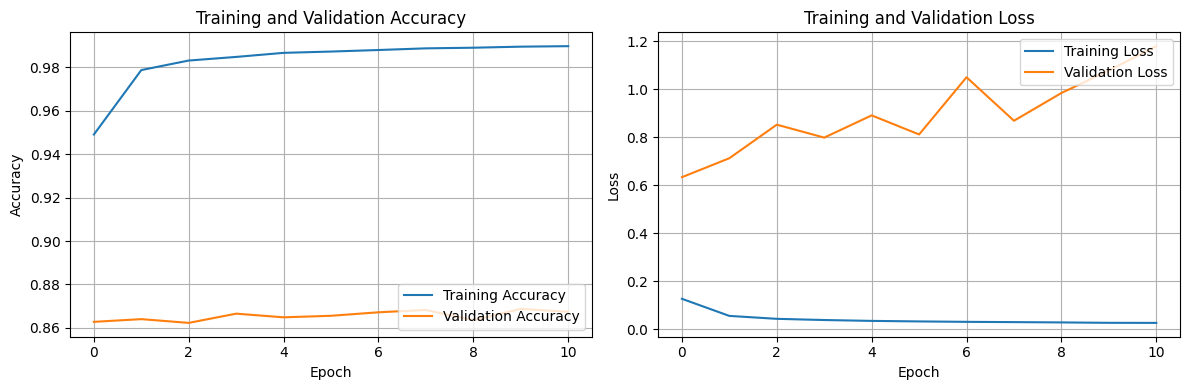

In [11]:
# Fungsi untuk plot history training
def plot_training_history(history):
    # Plot akurasi training dan validasi
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid(True)

    # Plot loss training dan validasi
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Panggil fungsi untuk memvisualisasikan history training
plot_training_history(history)

In [12]:
# Evaluasi pada test set
print("\n--- Mengevaluasi Model pada Test Set ---")
loss, accuracy = model.evaluate(X_test_scaled, y_test, verbose=0)
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Loss: {loss:.4f}")


--- Mengevaluasi Model pada Test Set ---
Test Accuracy: 0.8627
Test Loss: 0.6334


In [13]:
# Laporan Klasifikasi dan Confusion Matrix
print("\n--- Laporan Klasifikasi ---")
# Mendapatkan prediksi probabilitas
y_pred_proba = model.predict(X_test_scaled).flatten()
# Mengonversi probabilitas menjadi kelas biner (0 atau 1) dengan threshold 0.5
y_pred = (y_pred_proba > 0.5).astype(int)

# Mencetak laporan
print(classification_report(y_test, y_pred, target_names=['Non-Stress (0)', 'Stress (1)']))


--- Laporan Klasifikasi ---
1375/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
                precision    recall  f1-score   support

Non-Stress (0)       0.91      0.90      0.90     30863
    Stress (1)       0.76      0.78      0.77     13132

      accuracy                           0.86     43995
     macro avg       0.84      0.84      0.84     43995
  weighted avg       0.86      0.86      0.86     43995



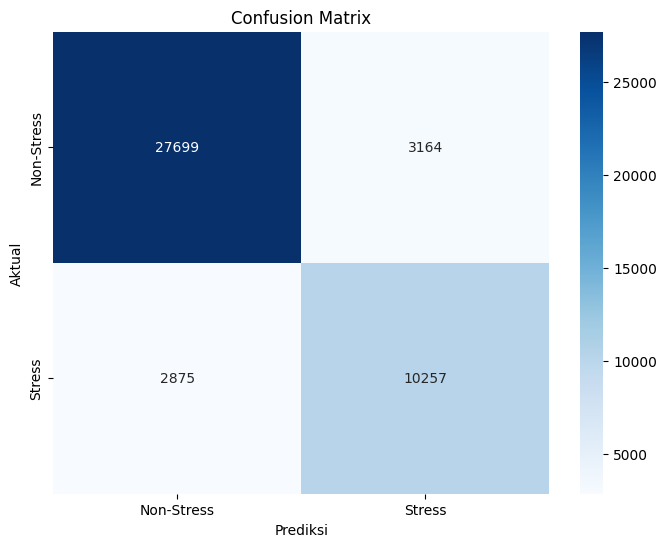

In [14]:
# Menampilkan confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Stress', 'Stress'], yticklabels=['Non-Stress', 'Stress'])
plt.xlabel('Prediksi')
plt.ylabel('Aktual')
plt.title('Confusion Matrix')
plt.show()

## Menyimpan Model

In [15]:
model.save('/kaggle/working/wesad_model.h5')